# Hourly PSDS - FFBI & TILT (N,E)

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys, gc
import pickle
import matplotlib.pyplot as plt

from functions.get_fband_average import __get_fband_average

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}

config['project'] = "2"

config['station'] = "ROMYT"

config['d1'], config['d2'] = "2024-01-01", "2024-01-31"

config['path_to_data'] = data_path+f"LNM2/PSDS{config['project']}/"

config['outpath_figures'] = data_path+f"LNM2/figures{config['project']}/"

config['frequency_limits'] = [1e-3, 1e0]

config['type'] = "acc" # rot | acc

## Methods

In [4]:
from functions.get_fband_averages import __get_fband_averages
from functions.replace_noise_psd_with_nan import __replace_noisy_psds_with_nan
from functions.get_median_psd import __get_median_psd
from functions.get_fband_averages import __get_fband_averages
from functions.cut_frequencies_array import __cut_frequencies_array

In [5]:
def __makeplot_colorlines_overview1(config, ff, psds, rejected, names, day, show_rejected=True):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    # ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)


    ##____________________________

    NN = 4

    fig, axes = plt.subplots(NN, 1, figsize=(12, 12), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24

    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)


    for j in range(NN):

        try:
            for n, psd in enumerate(psds[j]):
                axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
                p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N, zorder=3)

            if show_rejected:
                for reject in rejected[j]:
                     axes[j].loglog(ff[j],reject, color='grey', alpha=0.6, zorder=2)
        except:
            pass

        axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")

        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[j].set_xlim(1e-3, 2e0)
        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)

    ## limits of sensor noise
    # freq = arange(0.0001, 1, 0.001)
    # plim1 = 0.1**2 * ones(len(freq)) / 12 / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2 = 0.1**2 * ones(len(freq)) / 12/ (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # plim1_1 = 0.1**2 * ones(len(freq)) / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2_1 = 0.1**2 * ones(len(freq)) / (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # axes[1].loglog(freq, plim1, color="black", ls="--", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2, color="black", ls="--", zorder=4, alpha=0.7)

    # axes[1].loglog(freq, plim1_1, color="black", ls=":", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2_1, color="black", ls=":", zorder=4, alpha=0.7)

    axes[0].plot(df_models.frequencies, df_models.nlnm_acc, color="k", ls="--", alpha=0.6)
    axes[1].plot(df_models.frequencies, df_models.nlnm_acc, color="k", ls="--", alpha=0.6)

    axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .95, '(a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.01, .95, '(b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.01, .95, '(c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)
    axes[3].text(.01, .95, '(d)', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)

    sta, cha = names[0].split("_")[-2], names[0].split("_")[-1]
    axes[0].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)

    sta, cha = names[1].split("_")[-2], names[1].split("_")[-1]
    axes[1].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)

    sta, cha = names[2].split("_")[-2], names[2].split("_")[-1]
    axes[2].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)

    sta, cha = names[3].split("_")[-2], names[3].split("_")[-1]
    axes[3].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)

    axes[0].set_title(day, fontsize=font+2)

    axes[0].set_ylim(bottom=1e-18, top=1e-11)
    axes[1].set_ylim(bottom=1e-18, top=1e-11)
    axes[2].set_ylim(bottom=1e-6, top=1e4)
    axes[3].set_ylim(bottom=1e-6, top=1e5)

    axes[0].set_ylabel(r"PSD (m$^2$/s$^4$/Hz)", fontsize=font)
    axes[1].set_ylabel(r"PSD (m$^2$/s$^4$/Hz)", fontsize=font)
    axes[2].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)
    axes[3].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5, ticks=arange(1,N,2))


    plt.show();
    return fig

In [11]:
def __makeplot_colorlines_overview2(config, ff, psds, rejected, names, day, show_rejected=True):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)

    # ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)

    ##____________________________

    NN = 4

    fig, axes = plt.subplots(NN, 1, figsize=(12, 12), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24

    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)

    for j in range(NN):

        try:
            for n, psd in enumerate(psds[j]):
                axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
                p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N, zorder=3)

            if show_rejected:
                for reject in rejected[j]:
                     axes[j].loglog(ff[j],reject, color='grey', alpha=0.6, zorder=2)
        except:
            pass

        axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")

        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-2].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], color="grey", ls="--", alpha=0.8)
        axes[NN-1].loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], color="grey", ls="--", alpha=0.8)

        axes[j].set_xlim(1e-3, 2e0)
        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)

    ## limits of sensor noise
    # freq = arange(0.0001, 1, 0.001)
    # plim1 = 0.1**2 * ones(len(freq)) / 12 / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2 = 0.1**2 * ones(len(freq)) / 12/ (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # plim1_1 = 0.1**2 * ones(len(freq)) / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2_1 = 0.1**2 * ones(len(freq)) / (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # axes[1].loglog(freq, plim1, color="black", ls="--", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2, color="black", ls="--", zorder=4, alpha=0.7)

    # axes[1].loglog(freq, plim1_1, color="black", ls=":", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2_1, color="black", ls=":", zorder=4, alpha=0.7)

    axes[0].plot(df_models.frequencies, df_models.nlnm_rot_rate, color="k", ls="--", alpha=0.6)
    axes[1].plot(df_models.frequencies, df_models.nhnm_rot_rate, color="k", ls="--", alpha=0.6)

    axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .95, '(a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.01, .95, '(b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.01, .95, '(c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)
    axes[3].text(.01, .95, '(d)', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)

    sta, cha = names[0].split("_")[-2], names[0].split("_")[-1]
    axes[0].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)

    sta, cha = names[1].split("_")[-2], names[1].split("_")[-1]
    axes[1].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)

    sta, cha = names[2].split("_")[-2], names[2].split("_")[-1]
    axes[2].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)

    sta, cha = names[3].split("_")[-2], names[3].split("_")[-1]
    axes[3].text(.05, .95, f'{sta}.{cha}', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)

    axes[0].set_title(day, fontsize=font+2)

    axes[0].set_ylim(bottom=1e-23, top=1e-16)
    axes[1].set_ylim(bottom=1e-23, top=1e-16)
    axes[2].set_ylim(bottom=1e-6, top=1e4)
    axes[3].set_ylim(bottom=1e-6, top=1e5)

    axes[0].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[1].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font)
    axes[2].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)
    axes[3].set_ylabel(r"PSD (Pa$^2$/Hz)", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5, ticks=arange(1,N,2))


    plt.show();
    return fig

## RUN for all files 

In [7]:
baro_lnm = read_csv(data_path+f"LNM2/data/"+"baro_nlnm_nhnm.csv")

baro_lnm['nlnm_baro'] = 10**(baro_lnm['nlnm_baro_db']/10)
baro_lnm['nhnm_baro'] = 10**(baro_lnm['nhnm_baro_db']/10)

In [8]:
df_models = read_csv(data_path+"LNM/data/FINAL/"+"TLNM_to_RLNM.csv")

 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


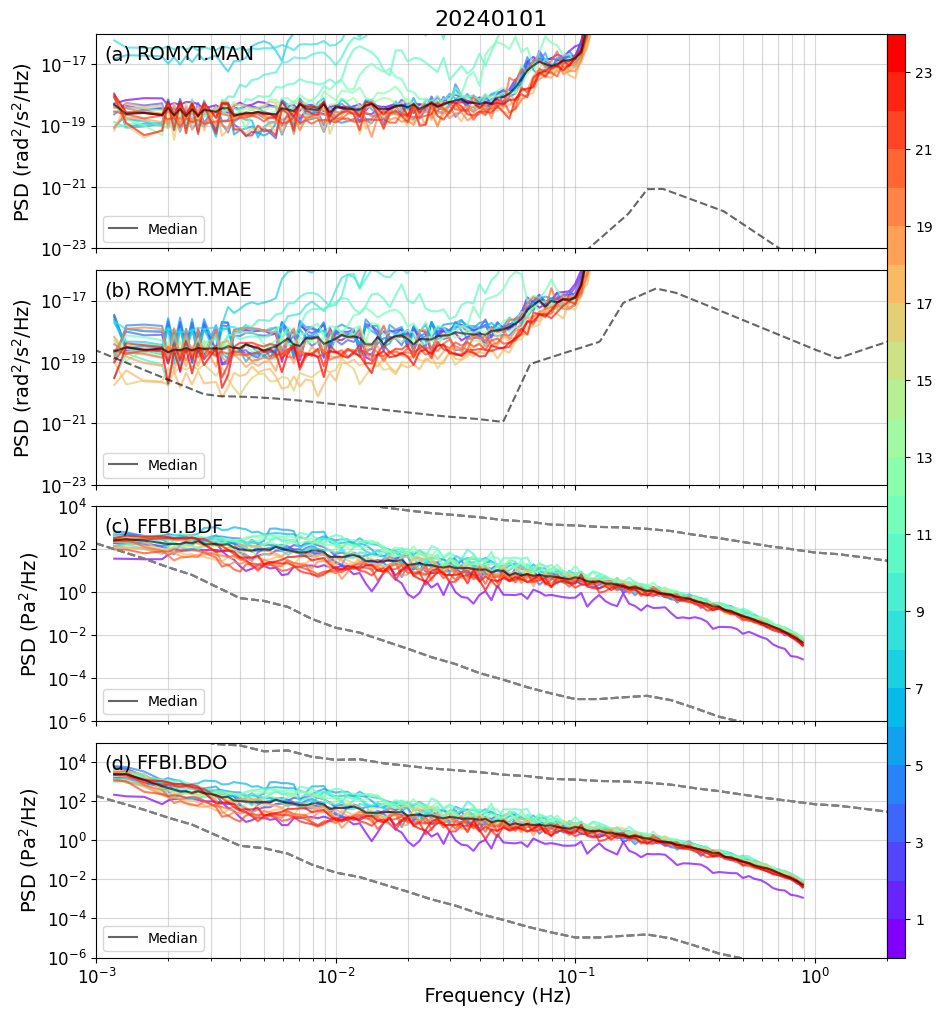

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240101.png


5773

 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain


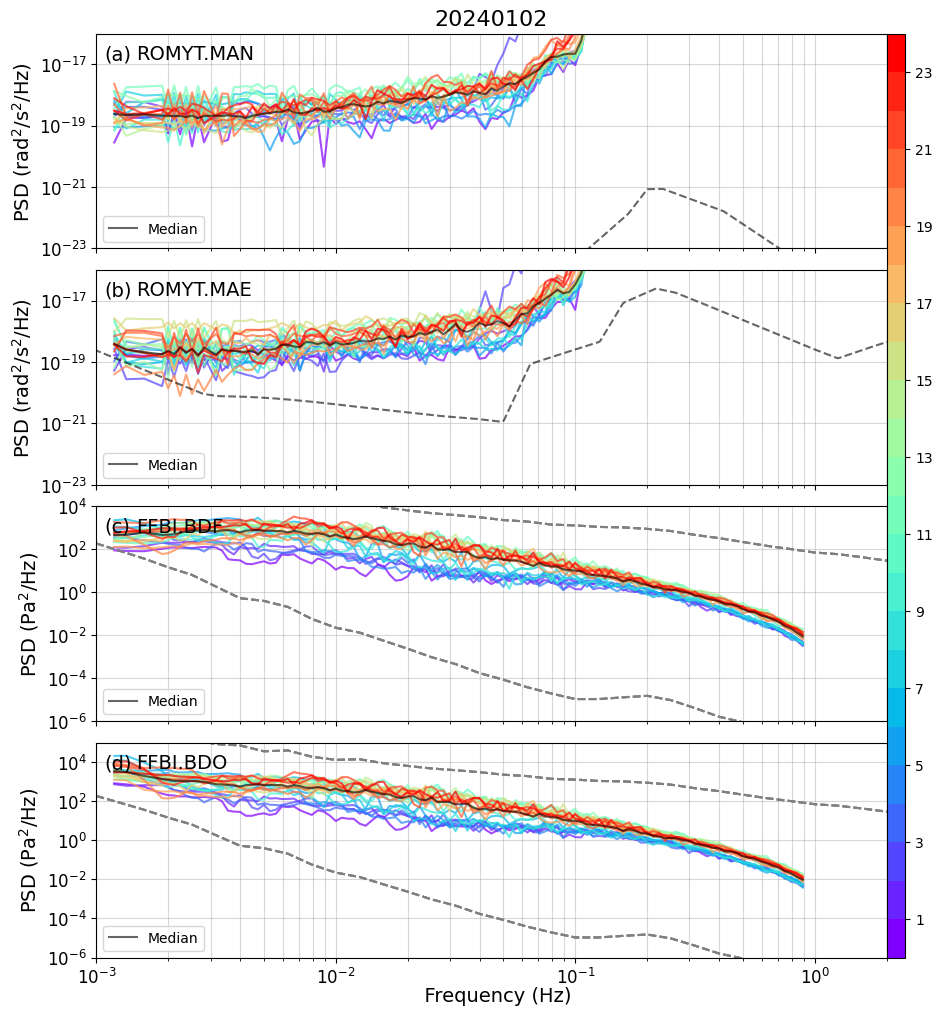

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240102.png


60234

 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain


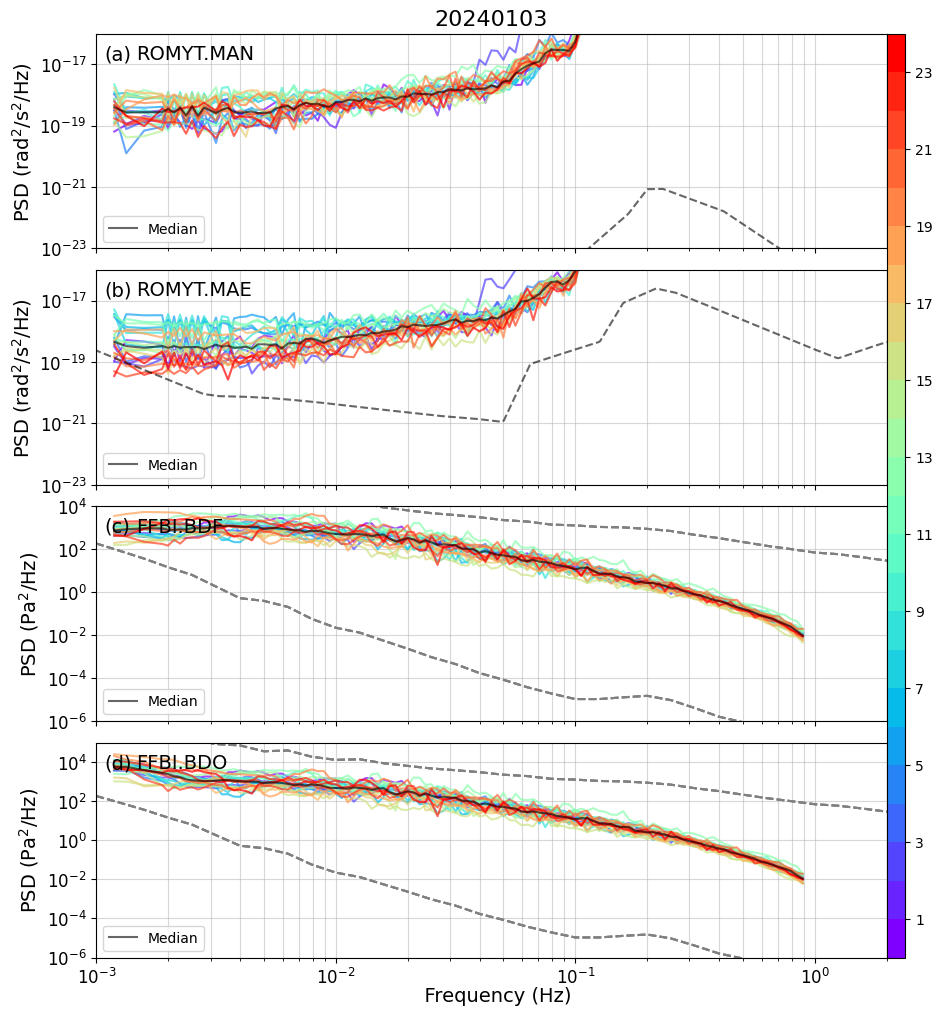

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240103.png


60234

 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain


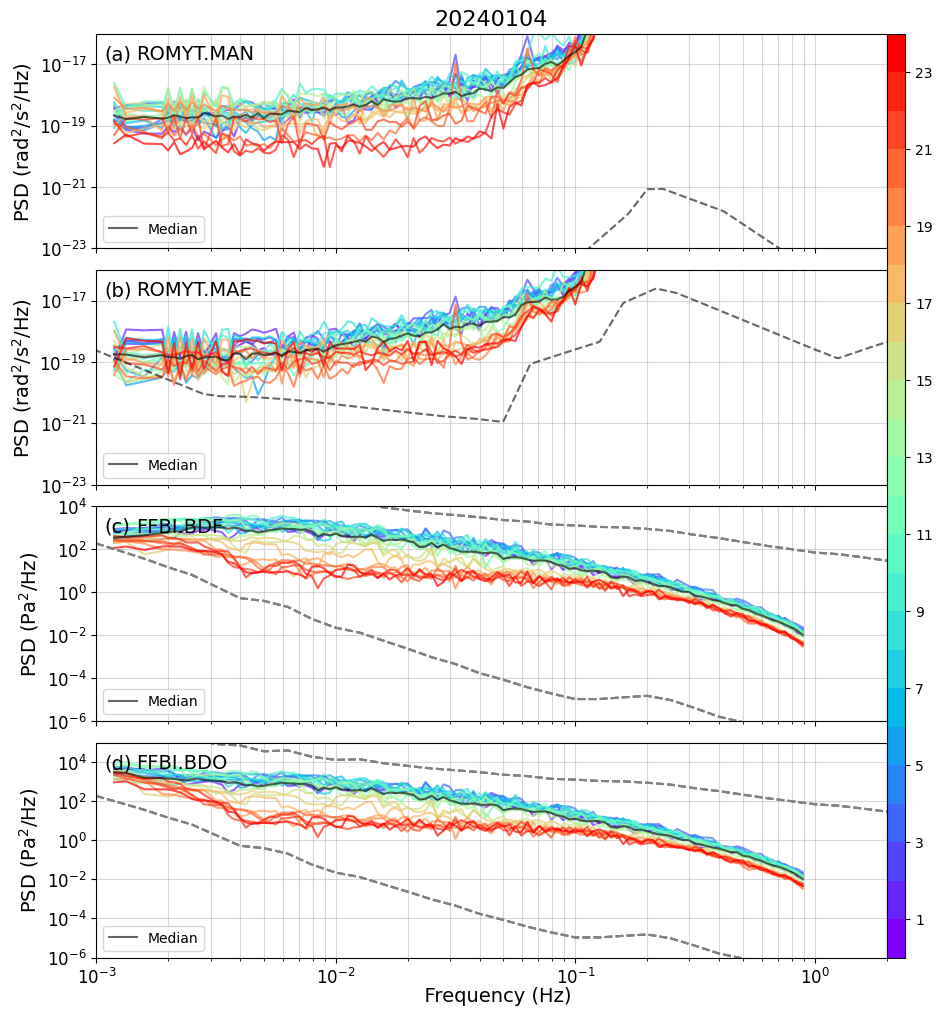

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240104.png


60234

 -> 1 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 23 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 1 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 23 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 1 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 23 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 1 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 23 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


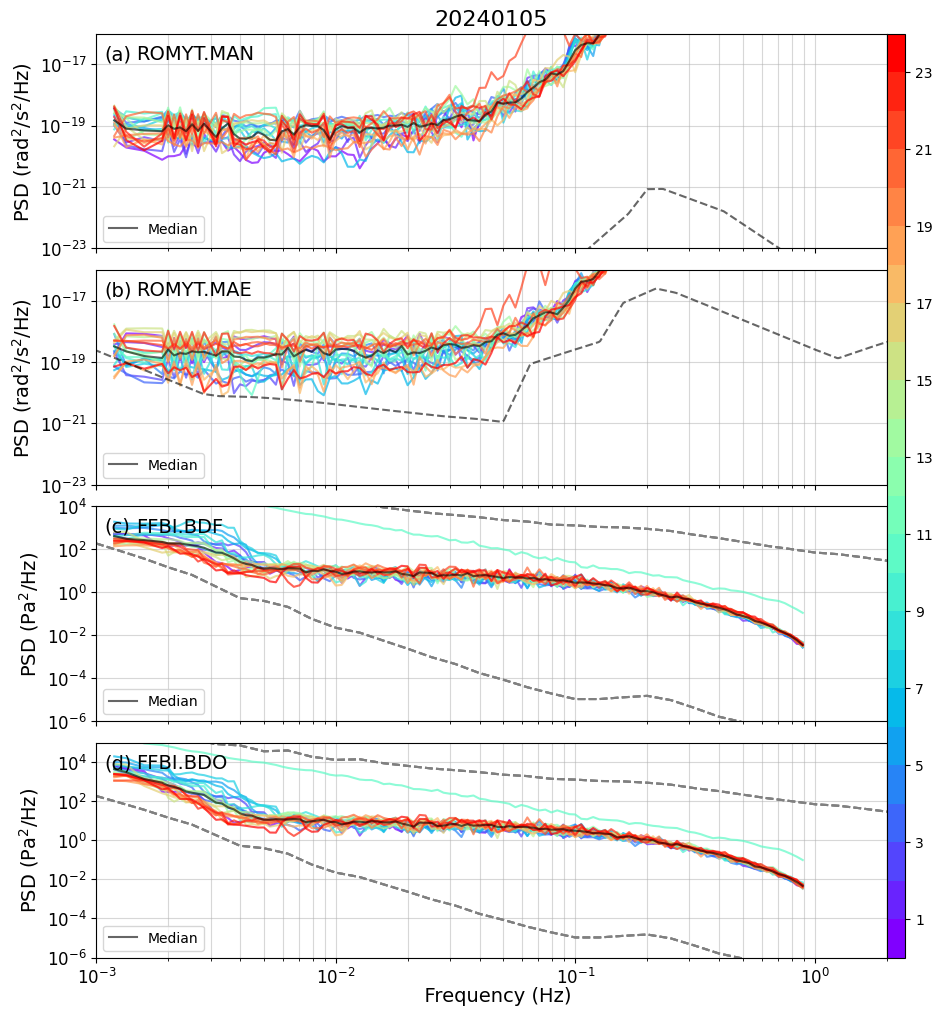

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240105.png


60274

 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain


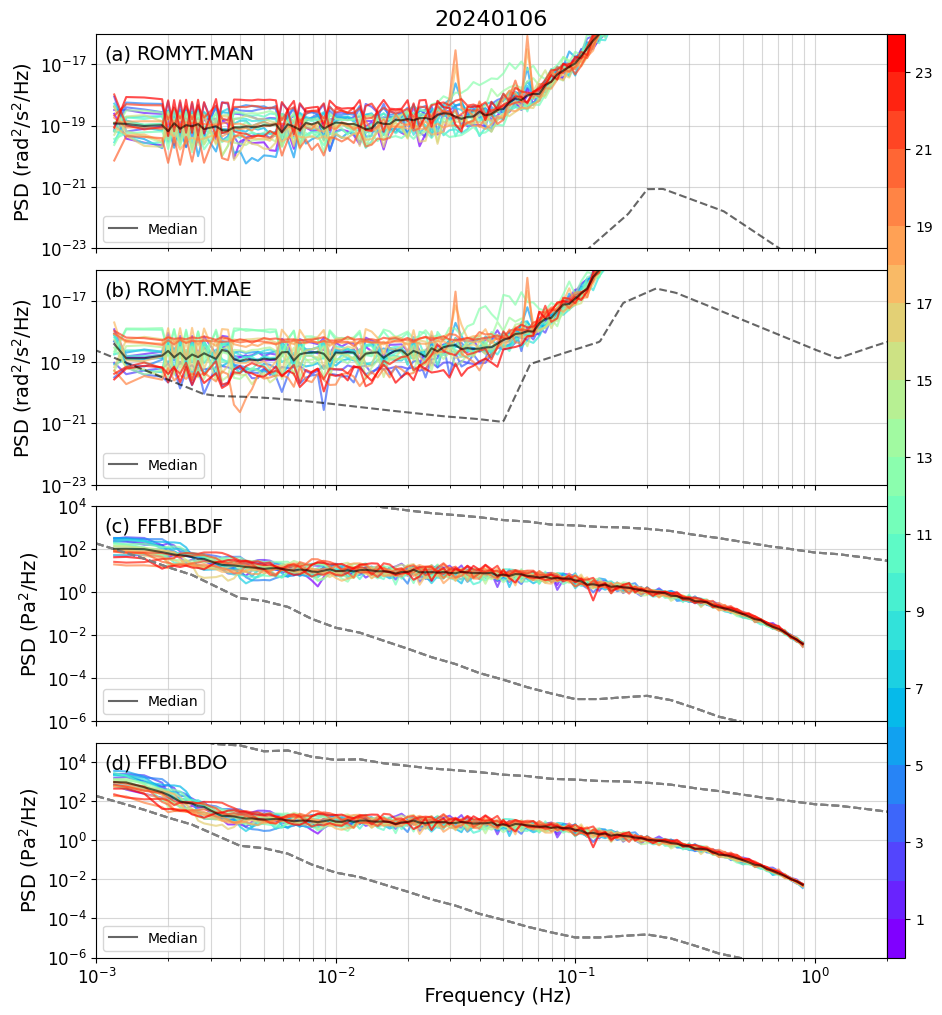

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240106.png


60234

 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain


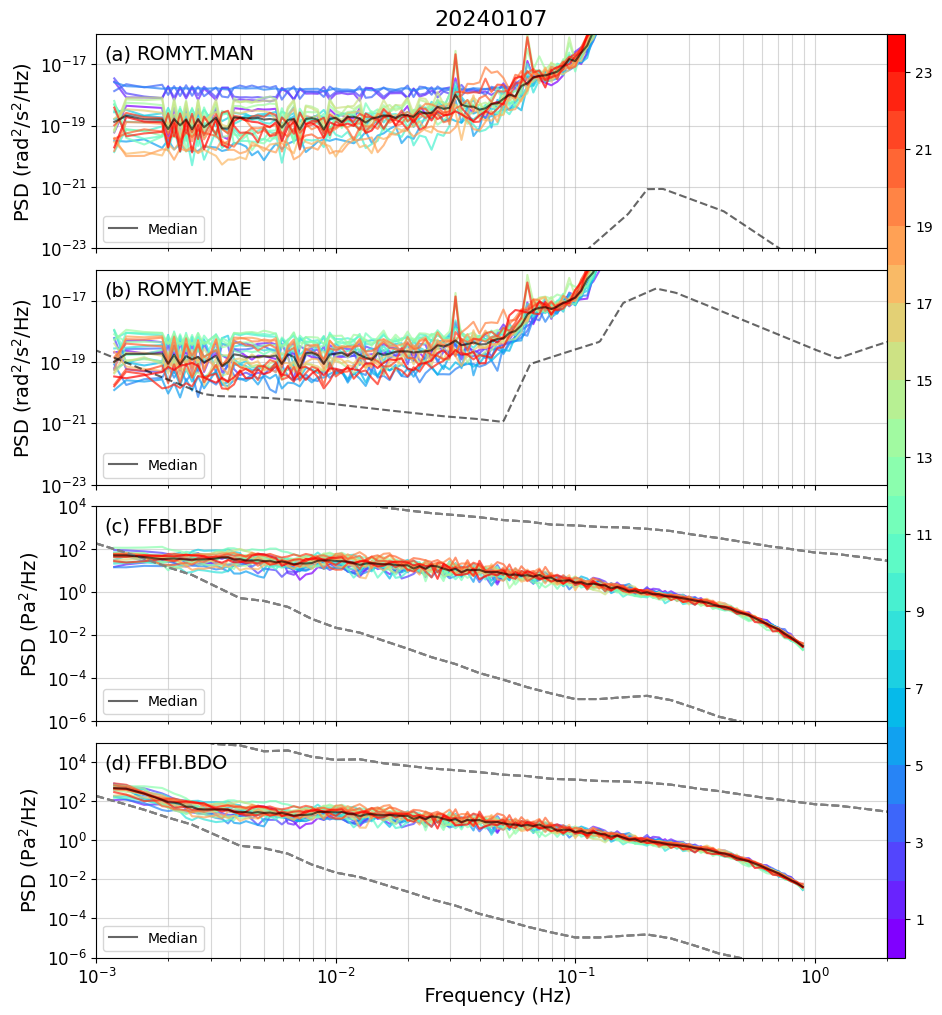

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240107.png


60234

 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


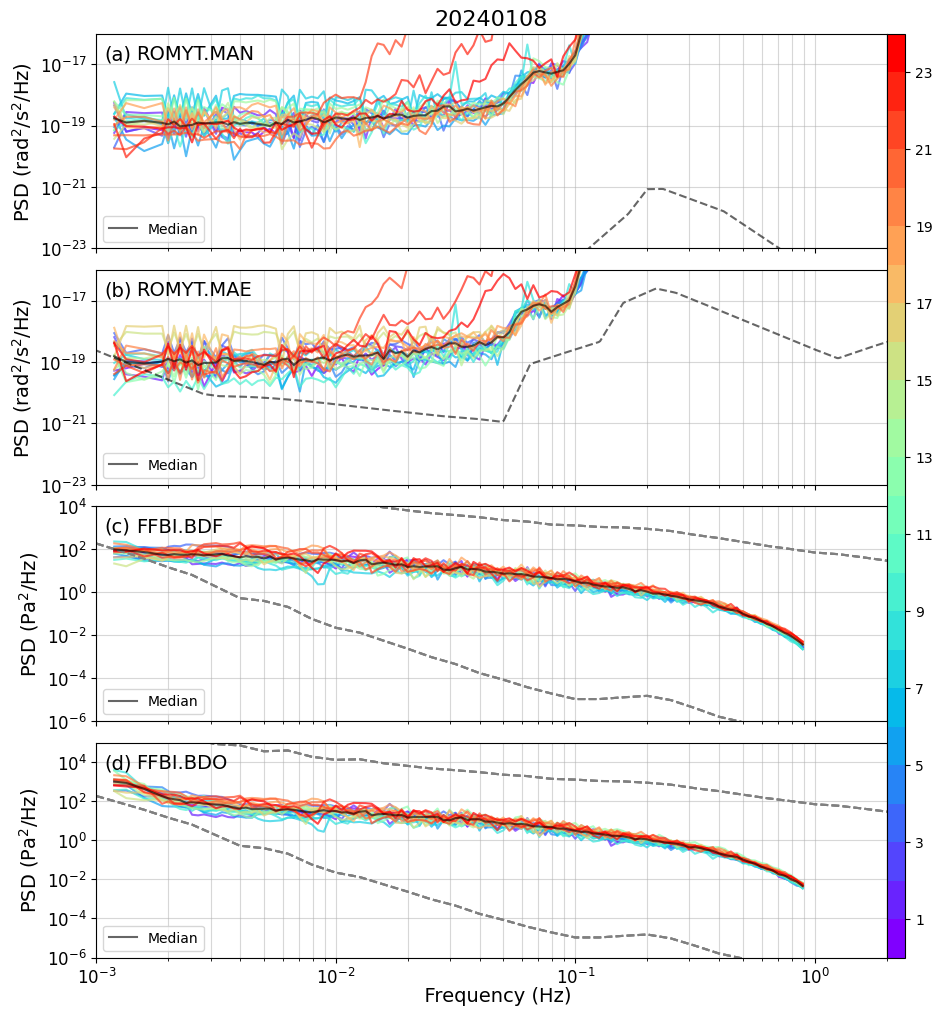

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240108.png


60234

 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain


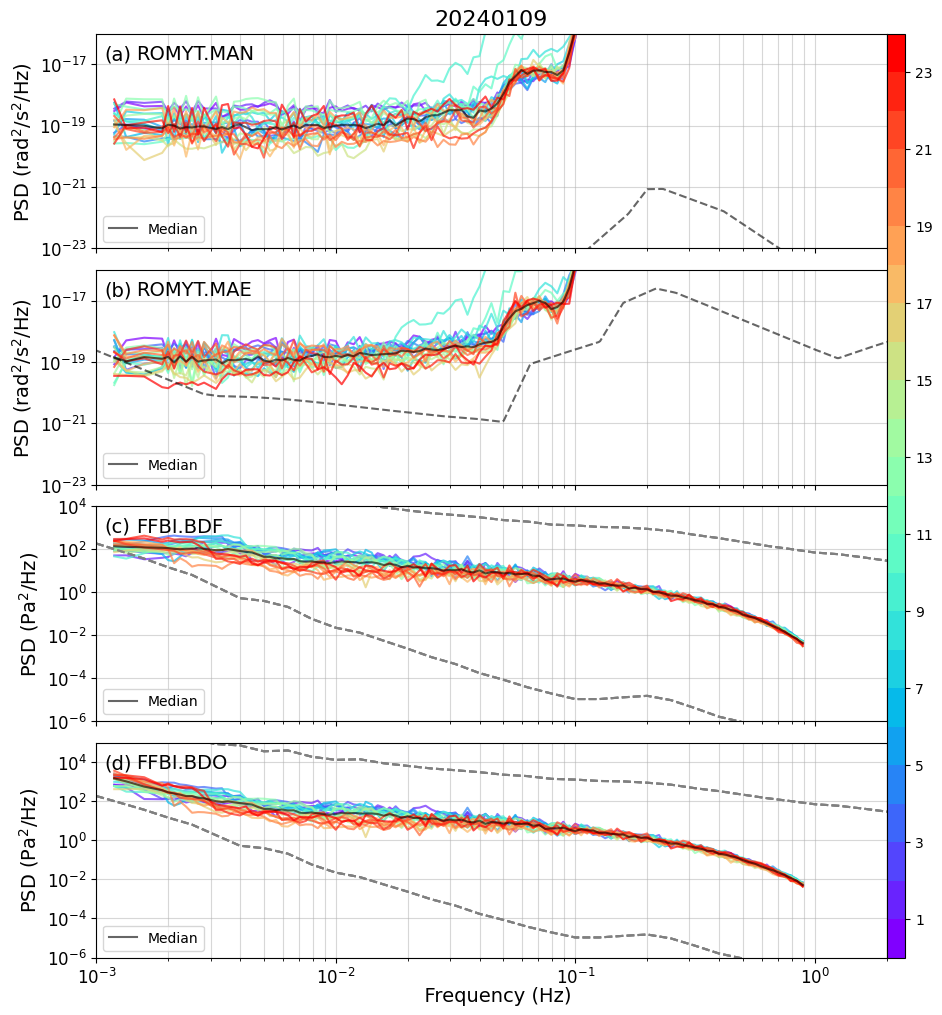

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240109.png


60234

 -> 3 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 21 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 3 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 21 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 3 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 21 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 3 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 21 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


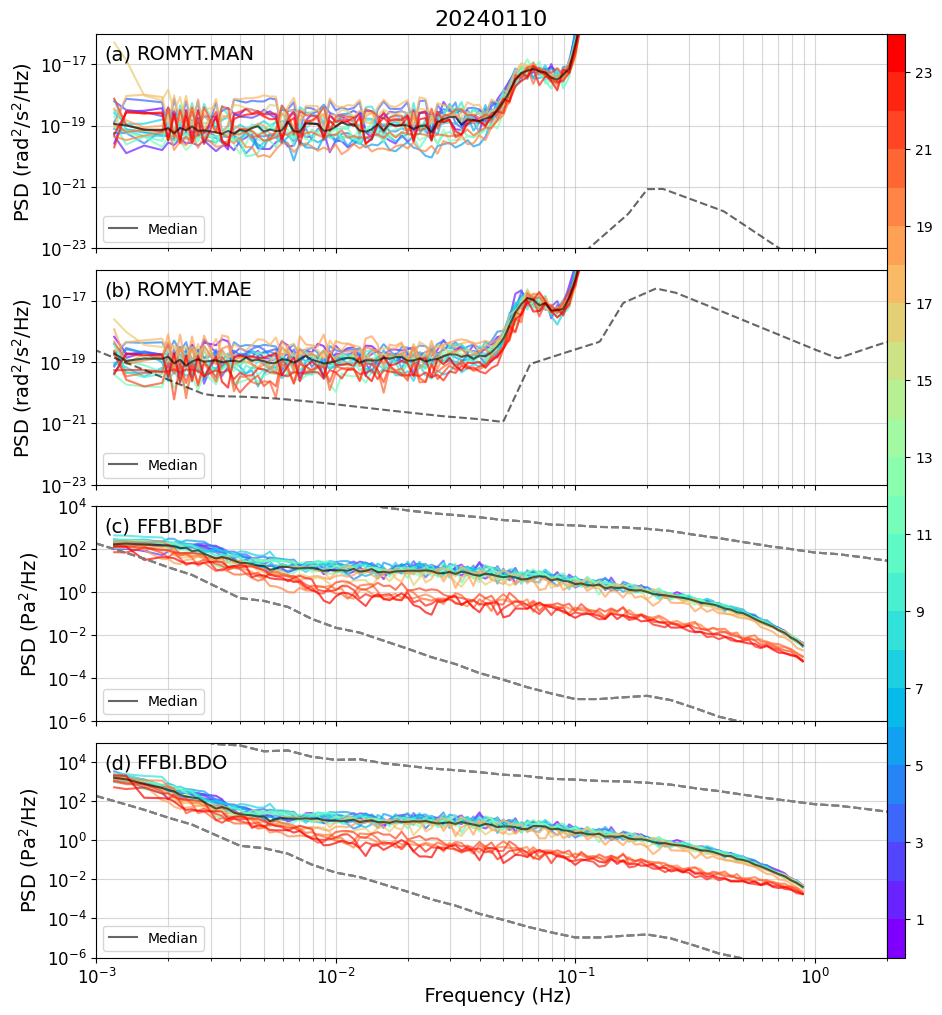

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240110.png


60239

 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain


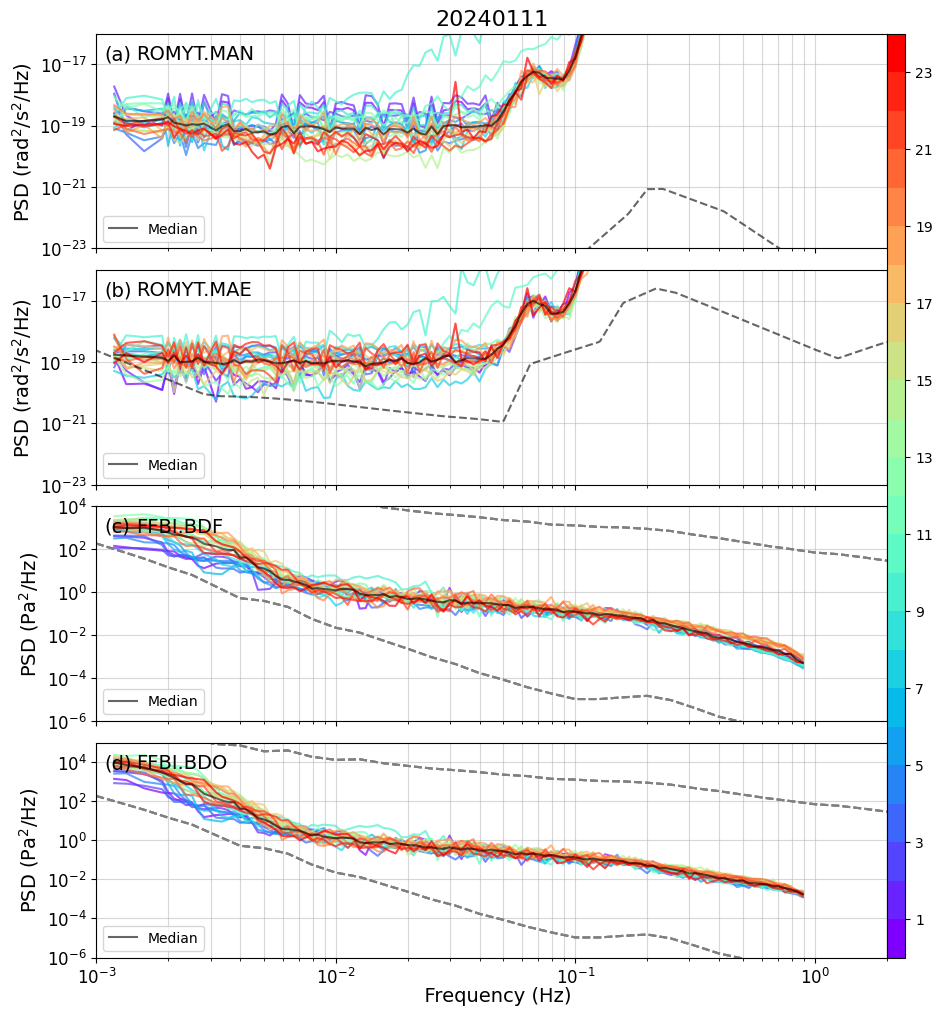

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240111.png


60234

 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


 -> 2 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 22 / 24 psds remain


/home/brotzer/notebooks/LowNoiseModel2/functions/get_fband_average.py:100: RuntimeWarning: All-NaN slice encountered
  psd_average.append(nanmedian(psd[ifl:ifu]))


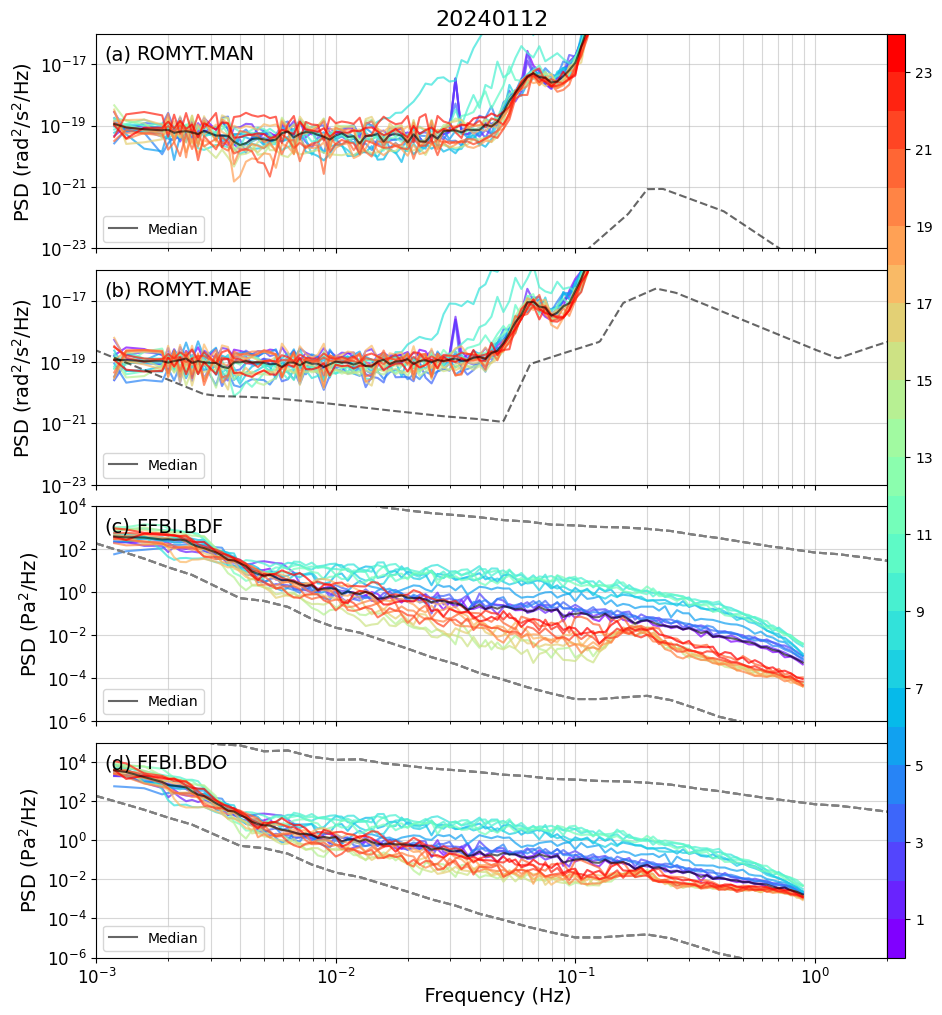

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240112.png


60234

 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain


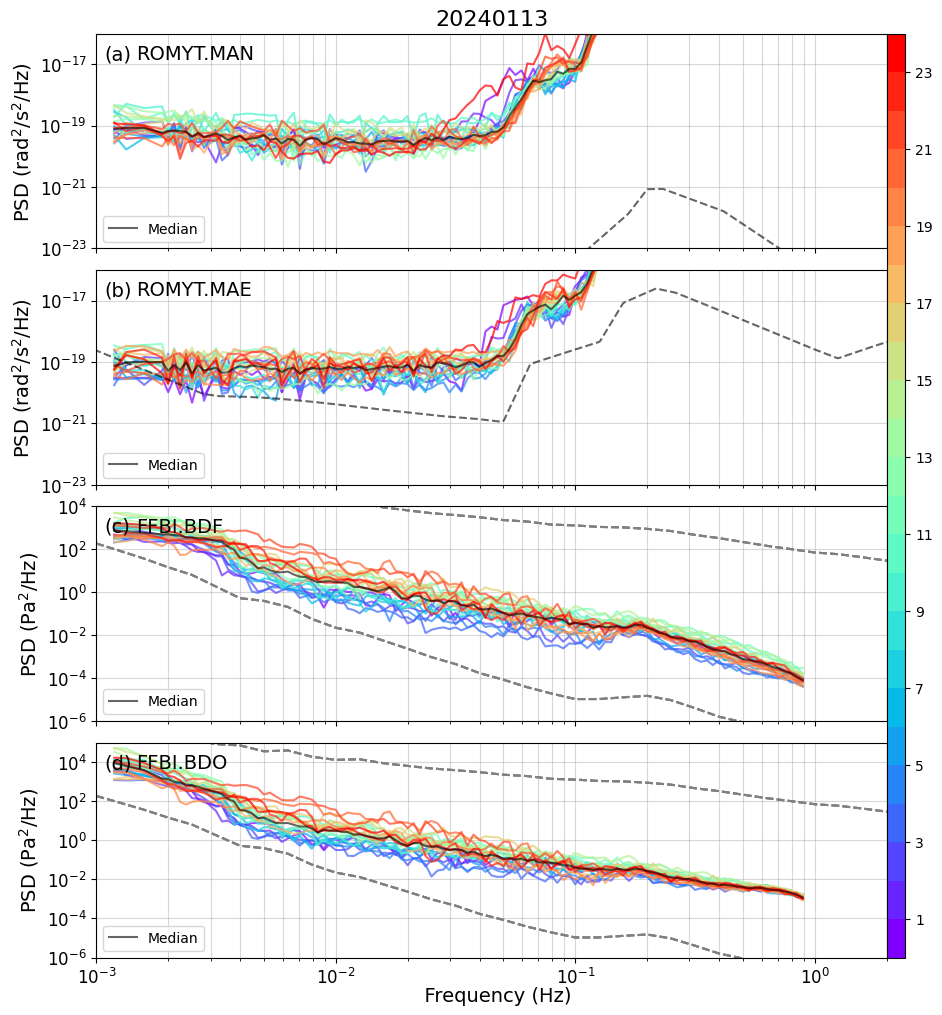

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240113.png


60234

 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain
 -> 0 are all NaN
 -> 0 rows removed due to mean thresholds (0.0011 and 0.9998 Hz)!
 -> 24 / 24 psds remain


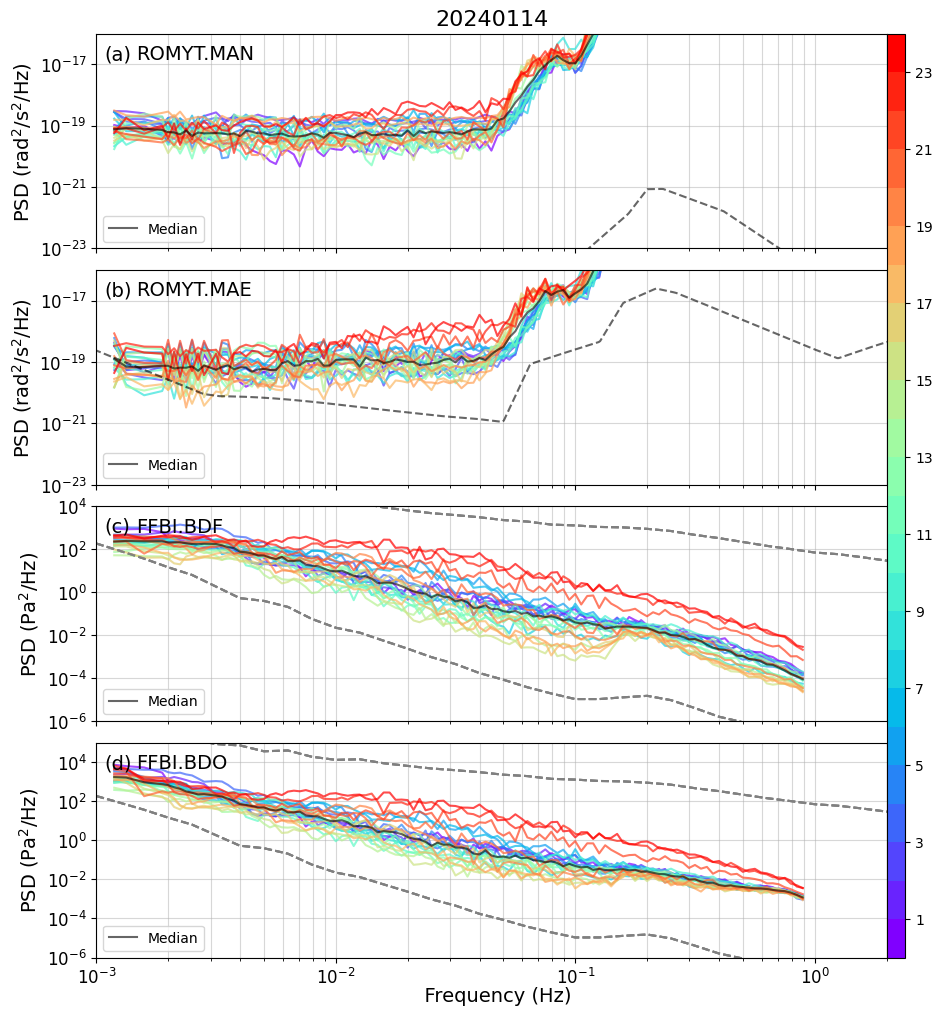

 -> saving: /import/kilauea-data/LNM2/figures2/joint_20240114.png



KeyboardInterrupt



In [12]:

psds_medians_out, times_out = [], []

for _i, day in enumerate(date_range(config['d1'], config['d2'])):

    day = str(day).split(" ")[0].replace("-", "")

    config['outpath_figname'] = "joint_"+day

    # if _i > 1:
    #     continue

    # if os.path.isfile(config['outpath_figures']+config['outpath_figname']):
    #     print(f" -> skipping {config['outpath_figname']} ...")
    #     continue


    try:

        # Data2 --------------------------
        name2 = "ROMYT/2024_ROMYT_MAN"

        out = read_pickle(config['path_to_data']+f"{name2}_3600_{day}_hourly.pkl")
        ff2, dat2 = out['frequencies'], out['psd']

        dat2, ff2 = __cut_frequencies_array(dat2, ff2, config['frequency_limits'][0], config['frequency_limits'][1])

        dat2, rejected_dat2 = __replace_noisy_psds_with_nan(dat2, ff2,
                                                            threshold_mean=None,
                                                            threshold_max=1e-8
                                                           )

        ff2, dat2 = __get_fband_averages(ff2, dat2)

        # Data3 --------------------------
        name3 = "ROMYT/2024_ROMYT_MAE"

        out = read_pickle(config['path_to_data']+f"{name3}_3600_{day}_hourly.pkl")
        ff3, dat3 = out['frequencies'], out['psd']

        dat3, ff3 = __cut_frequencies_array(dat3, ff3, config['frequency_limits'][0], config['frequency_limits'][1])

        dat3, rejected_dat3 = __replace_noisy_psds_with_nan(dat3, ff3,
                                                            threshold_mean=None,
                                                            threshold_max=1e-8
                                                           )

        ff3, dat3 = __get_fband_averages(ff3, dat3)

        # Data4 --------------------------
        name4 = "FFBI/2024_FFBI_BDF"

        out = read_pickle(config['path_to_data']+f"{name4}_3600_{day}_hourly.pkl")
        ff4, dat4 = out['frequencies'], out['psd']

        dat4, ff4 = __cut_frequencies_array(dat4, ff4, config['frequency_limits'][0], config['frequency_limits'][1])

        dat4, rejected_dat4 = __replace_noisy_psds_with_nan(dat4, ff4,
                                                            threshold_mean=None,
                                                            threshold_max=1e7
                                                           )

        ff4, dat4 = __get_fband_averages(ff4, dat4)

        # Data5 --------------------------
        name5 = "FFBI/2024_FFBI_BDO"

        out = read_pickle(config['path_to_data']+f"{name5}_3600_{day}_hourly.pkl")
        ff5, dat5 = out['frequencies'], out['psd']

        dat5, ff5 = __cut_frequencies_array(dat5, ff5, config['frequency_limits'][0], config['frequency_limits'][1])

        dat5, rejected_dat5 = __replace_noisy_psds_with_nan(dat5, ff5,
                                                            threshold_mean=None,
                                                            threshold_max=1e7
                                                           )

        ff5, dat5 = __get_fband_averages(ff5, dat5)

    except Exception as e:
        print(e)
        continue

    if config['type'] == "rot":
        fig = __makeplot_colorlines_overview2(config,
                                             [ff2, ff3, ff4, ff5],
                                             [dat2, dat3, dat4, dat5],
                                             [rejected_dat2, rejected_dat3, rejected_dat4, rejected_dat5],
                                             [name2, name3, name4, name5],
                                             day,
                                             show_rejected=True)

    elif  config['type'] == "acc":
        fig = __makeplot_colorlines_overview1(config,
                                             [ff2, ff3, ff4, ff5],
                                             [dat2, dat3, dat4, dat5],
                                             [rejected_dat2, rejected_dat3, rejected_dat4, rejected_dat5],
                                             [name2, name3, name4, name5],
                                             day,
                                             show_rejected=True)

    print(f" -> saving: {config['outpath_figures']}{config['outpath_figname']}.png")
    fig.savefig(config['outpath_figures']+"joint_TILT/"+config['outpath_figname']+"_TILT.png", format="png", transparent=False, bbox_inches='tight', dpi=200)

    del fig
    gc.collect()